<center><h1><b><mark style="background-color: #ff1493; color: black;">IP CW Draft</mark></b></h1></center>


In this coursework, you will be asked to develop an image processing pipeline to separate flower material from background. This requires a processing pipeline that usually includes at least some of the following steps:

- <b>Colour space conversion</b>: choose a colour space. Any can be used, but most people choose to work in a lower-dimensional (<3) space whenever possible.

- <b>Noise reduction</b>: depending on image quality, some form of noise suppression may be required.

- <b>Thresholding/Segmentation</b>: image regions corresponding to nuclei must be identified, and thresholding is a common approach. The method used varies and may be global or local. Methods that automatically determine the threshold value  have obvious advantages over those that require user interaction. Binary image processing: Identifying a perfect threshold value or segmentation  method is almost impossible, and most methods will result in some mis-classified  pixels. A further binary image processing stage is often needed to clean up the image, hopefully leaving it containing only regions that correspond to plants.  Nothing, however, is perfect.

- <b>Dataset</b>: Images of three species of flowers are collected in a folder available from  Moodle. The images are selected based on the complexity of their foreground/background features and categorised into three sub-folders (e.g., easy, medium, and hard) within the input-image folder. To aid with analysing the effectiveness of your solution, ground truth for each image is provided within the  ground-truth folder, again categorised within three sub-folders (e.g., easy, medium, and hard).

https://www.researchgate.net/publication/286225842_Flower_recognition_system_based_on_image_processing


In [73]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import imageio
from skimage import morphology
from skimage.segmentation import watershed
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.measure import regionprops, label


def convert_BW(img):
    
    # converts the image to grayscale
    
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_bw

def negation(img):
    # Ensure the image is in uint8 format
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    negated_image = 255 - img
    return negated_image

def inc_gain(img,gain_factor):
    scaled_image = img * gain_factor
    scaled_image[scaled_image > 255] = 255
    return scaled_image

def histogramEq(img):
    # Convert the input image to a supported depth format (e.g., 8-bit)
    img = img.astype(np.uint8)

    # Convert the input image to grayscale if it's in color
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img

    # Apply histogram equalization
    eq_img = cv2.equalizeHist(gray_img)

    return eq_img

def otsu_threshold(img):
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    
    if gray_img.dtype != 'uint8':
        gray_img = gray_img.astype('uint8')
    _, otsu_threshold = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return otsu_threshold

def gamma_Correction(img, g):
    gamma = g
    gamma_img = ((img / 255) ** gamma) * 255
    gamma_img = gamma_img.astype("uint8")
    return gamma_img

def draw_border(binary_image):
    bordered_image = binary_image.copy()
    height, width = binary_image.shape[:2]
    cv2.rectangle(bordered_image, (0, 0), (width-1, height-1), 255, thickness=15)
    return bordered_image

  # roi for flowers using canny edge detection and choosing largest contour assuming that is the flower
def create_flower_mask(image):
    gray_image = image

    bilateral_filtered = cv2.bilateralFilter(gray_image, 9, 75, 75)
    edges = cv2.Canny(bilateral_filtered, 50, 150)
    dilated_edges = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=2)

    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    inverted_mask = cv2.bitwise_not(mask)

    roi = cv2.bitwise_and(image, image, mask=mask)
    roi[mask == 0] = 255

    return roi,largest_contour

def erosion(binary_image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    
    return eroded_image

  
def extract_foreground(image): 
    if image.dtype != 'uint8':
        image = image.astype('uint8')
    height, width = image.shape[:2]
    mask = np.zeros(image.shape[:2], np.uint8)
    rectangle = (1, 1, width, height)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.convertScaleAbs(image)
    cv2.grabCut(image, mask, rectangle, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT) # 5
    foreground_mask = np.where((mask == 1) | (mask == 3), 255, 0).astype('uint8')
    foreground = cv2.bitwise_and(image, image, mask=foreground_mask)
    return foreground


def sharpen_img(image, strength=1.5, sigma=1.0):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

def roi(binary_image):
    inverted_image = np.logical_not(binary_image) # invert colors of binary image
    labeled_image = label(inverted_image)# Label connected components in the inverted binary image
    regions = regionprops(labeled_image)# calculate properties of labeled regions
    largest_label = max(regions, key=lambda region: region.area).label# find label of largest component
    largest_black_blob_mask = labeled_image == largest_label# mask containing only the largest component (black blob)
    largest_black_blob_image = np.zeros_like(binary_image)# mask to the inverted binary image to obtain the largest black blob
    largest_black_blob_image[largest_black_blob_mask] = 1
    return largest_black_blob_image

def calculate_miou(ground_truth, final):
    print(ground_truth.shape)
    print(final.shape)
    similarity = ssim(ground_truth, final)
    return similarity
  
def calculate_iou(ground_truth, final):
    intersection = np.logical_and(ground_truth, final)
    union = np.logical_or(ground_truth, final)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# some of ground truths have uneven borders - this interferes with the similarity index.
# therefore border detection is carried out, if more than 75% of each edge of the image has a border
# it is considered for border removal.

def has_black_border(binary_image, threshold=0.75):
    height, width = binary_image.shape  # get the dimensions of the image
    binary_image = np.array(binary_image)
    top_black_pixels = np.sum(binary_image[0, :] == 0) # calculate the number of black pixels on each edge
    bottom_black_pixels = np.sum(binary_image[height-1, :] == 0)
    left_black_pixels = np.sum(binary_image[:, 0] == 0)
    right_black_pixels = np.sum(binary_image[:, width-1] == 0)
    top_percentage = top_black_pixels / width # calculate the percentage of black pixels on each edge
    bottom_percentage = bottom_black_pixels / width
    left_percentage = left_black_pixels / height
    right_percentage = right_black_pixels / height
    if (top_percentage > threshold and
        bottom_percentage > threshold and
        left_percentage > threshold and
        right_percentage > threshold): # check if the percentages exceed the threshold
        return True
    else:
        return False

# customizable function to apply all processing functions to image
def image_pipeline(img,ground):

    bw_img = convert_BW(img)
    gamma_img= gamma_Correction(bw_img,3.0)
    foreground_img = extract_foreground(gamma_img)
    negated_img = negation(foreground_img)  
    hist_eq_img = histogramEq(negated_img)
    otsu_thresh_img = otsu_threshold(hist_eq_img)
    final_img = roi(otsu_thresh_img)
    
    # processing ground truths
    # 1. converting to binary image using binary thresholding
    # 2. perform border detection (some of the ground truth images have borders, these interfere with the similarity index)
    # 3. if borders exist, remove the borders
    # 4. perform erosion on ground truth images to improve their similarity to the original image.
    
    #     if (has_black_border(ground_t) == True):
#         final_ground_t = negation(draw_border(ground_t))
#     else:
#         final_ground_t = negation(ground_t)

    _, ground_t = cv2.threshold(convert_BW(ground), 50, 255, cv2.THRESH_BINARY)
    final_ground_t = roi((ground_t))

    print("miou similarity: ",calculate_miou(final_ground_t,final_img))
    print("iou similarity: ",calculate_iou(final_ground_t,final_img))

    
    # display half-processed images
    images = [bw_img, gamma_img, foreground_img, negated_img, hist_eq_img, otsu_thresh_img, final_img, final_ground_t]
    titles = ["bw","gamma", "fground", "negate","histogram equalisation", "otsu threshold", "final", "ground_t"]
    fig, axes = plt.subplots(2, 4, figsize=(15, 7))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [2]:
def display_pipeline(image_pipeline):

    file_names = ["easy","medium","hard"]
    input_file_directory = "C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\input_images\\"
    ground_truth_directory =  "C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\ground_truths\\"
    
    for j in file_names:
        
        first_file_directory = input_file_directory+j+"\\"+j+"_"+"1"+".jpg"
        sec_file_directory = input_file_directory+j+"\\"+j+"_"+"2"+".jpg"
        third_file_directory = input_file_directory+j+"\\"+j+"_"+"3"+".jpg"
        
        ground1=ground_truth_directory+j+"\\"+j+"_"+"1"+".png"
        ground2=ground_truth_directory+j+"\\"+j+"_"+"2"+".png"
        ground3=ground_truth_directory+j+"\\"+j+"_"+"3"+".png"

        # getting input images
        image1=cv2.imread(first_file_directory, cv2.IMREAD_COLOR)
        image2=cv2.imread(sec_file_directory, cv2.IMREAD_COLOR)
        image3=cv2.imread(third_file_directory, cv2.IMREAD_COLOR)

        # getting all processed images
        gimage1=cv2.imread(ground1, cv2.IMREAD_COLOR)
        gimage2=cv2.imread(ground2, cv2.IMREAD_COLOR)
        gimage3=cv2.imread(ground3, cv2.IMREAD_COLOR)
        
        # getting final images
        fimage1=image_pipeline(image1,gimage1)
        fimage2=image_pipeline(image2,gimage2)
        fimage3=image_pipeline(image3,gimage3)

(500, 666)
(500, 666)
miou similarity:  0.9916607771518556
iou similarity:  0.7881620554664343


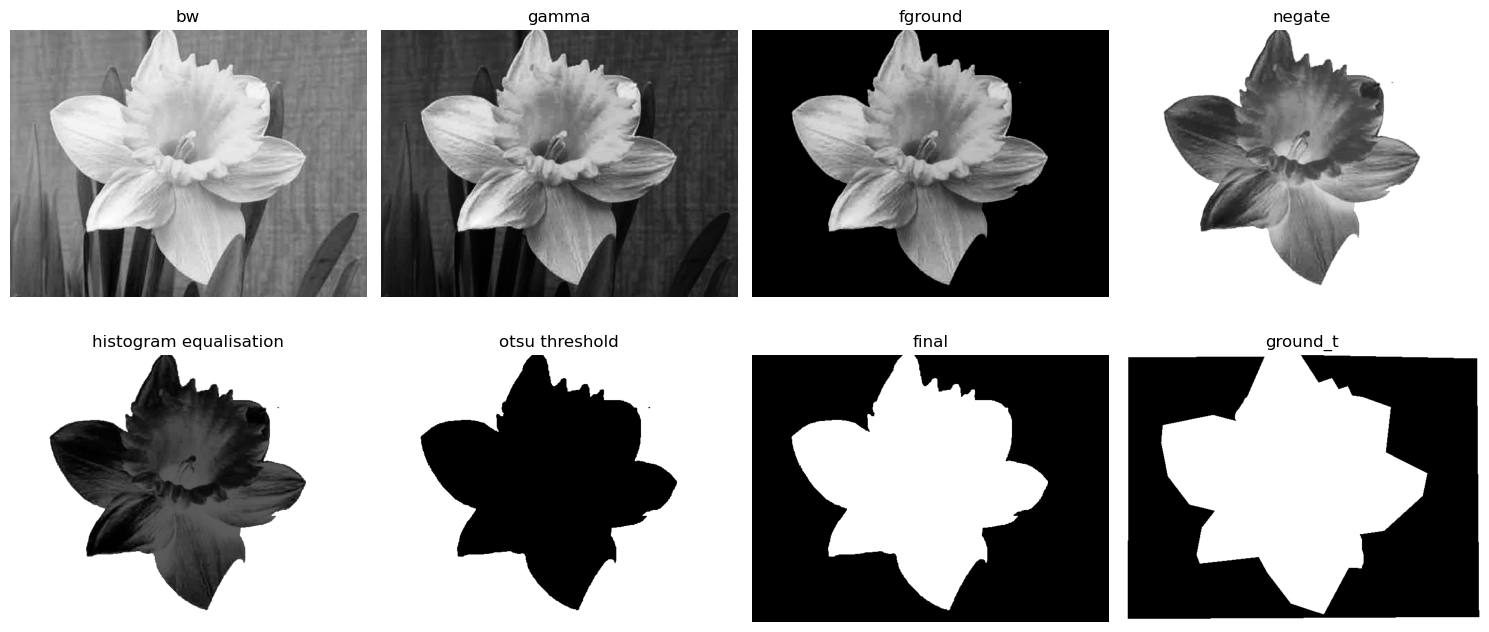

(500, 666)
(500, 666)
miou similarity:  0.9847995570664174
iou similarity:  0.6913187177785718


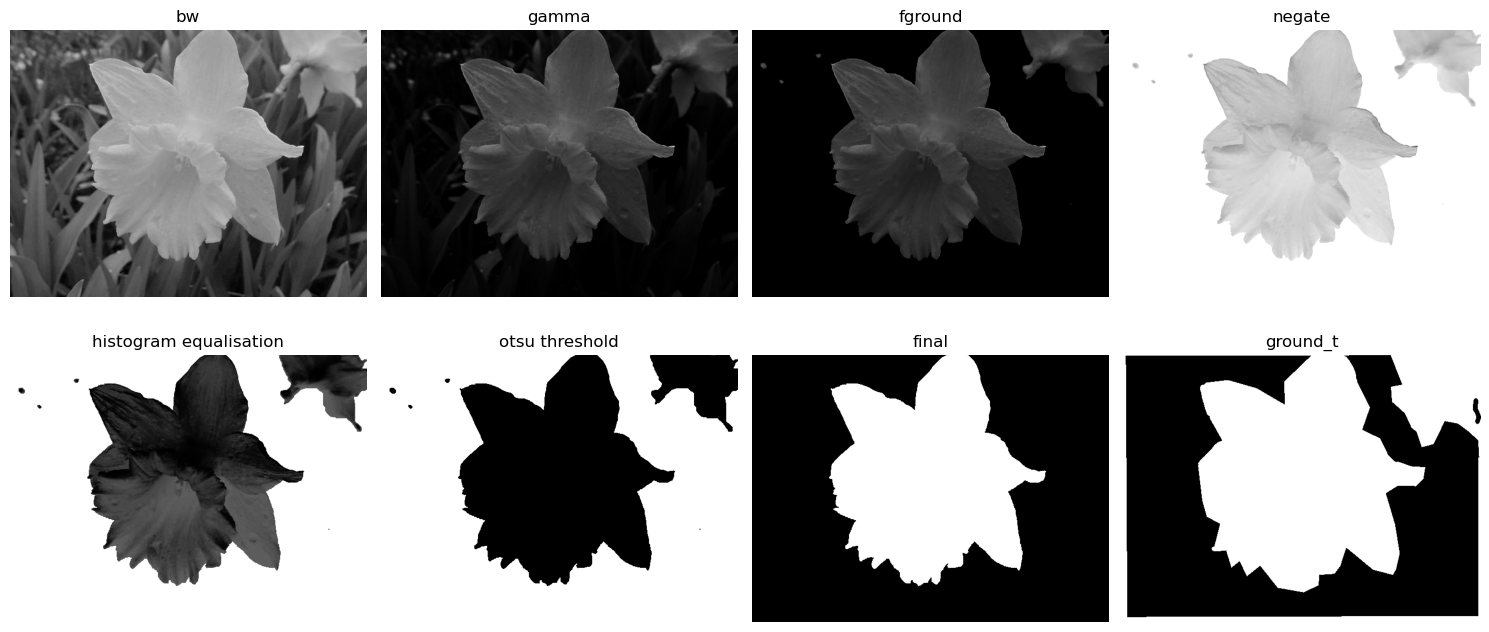

(500, 666)
(500, 666)
miou similarity:  0.9947476271711689
iou similarity:  0.8407245100851725


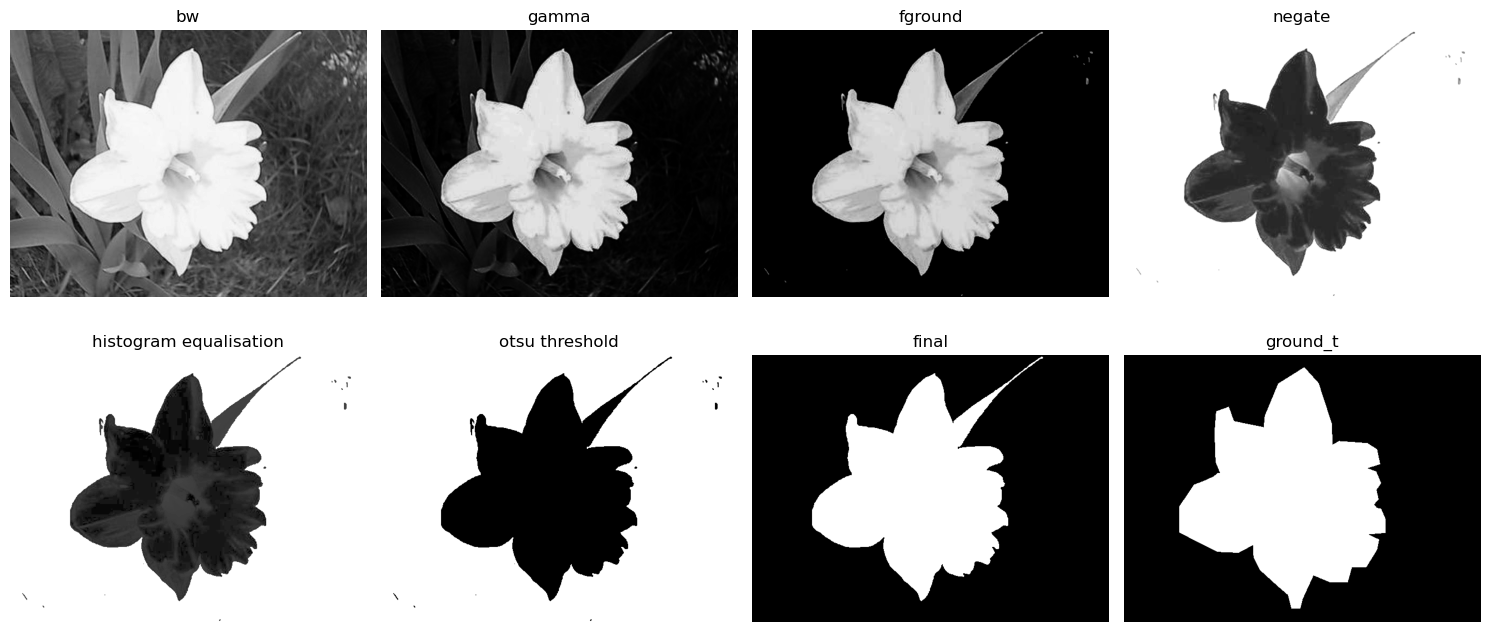

(529, 500)
(529, 500)
miou similarity:  0.9799908983116384
iou similarity:  0.6982155649625529


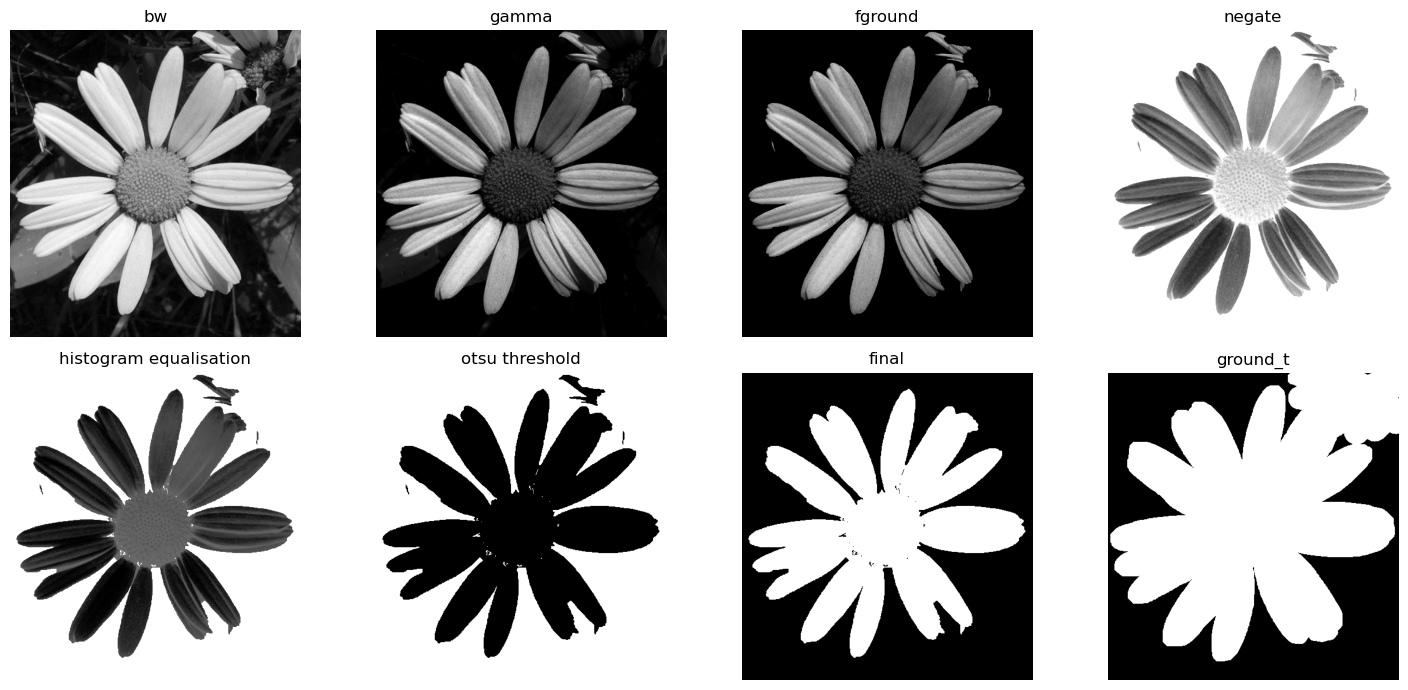

(500, 750)
(500, 750)
miou similarity:  0.9913427355829691
iou similarity:  0.85082692924299


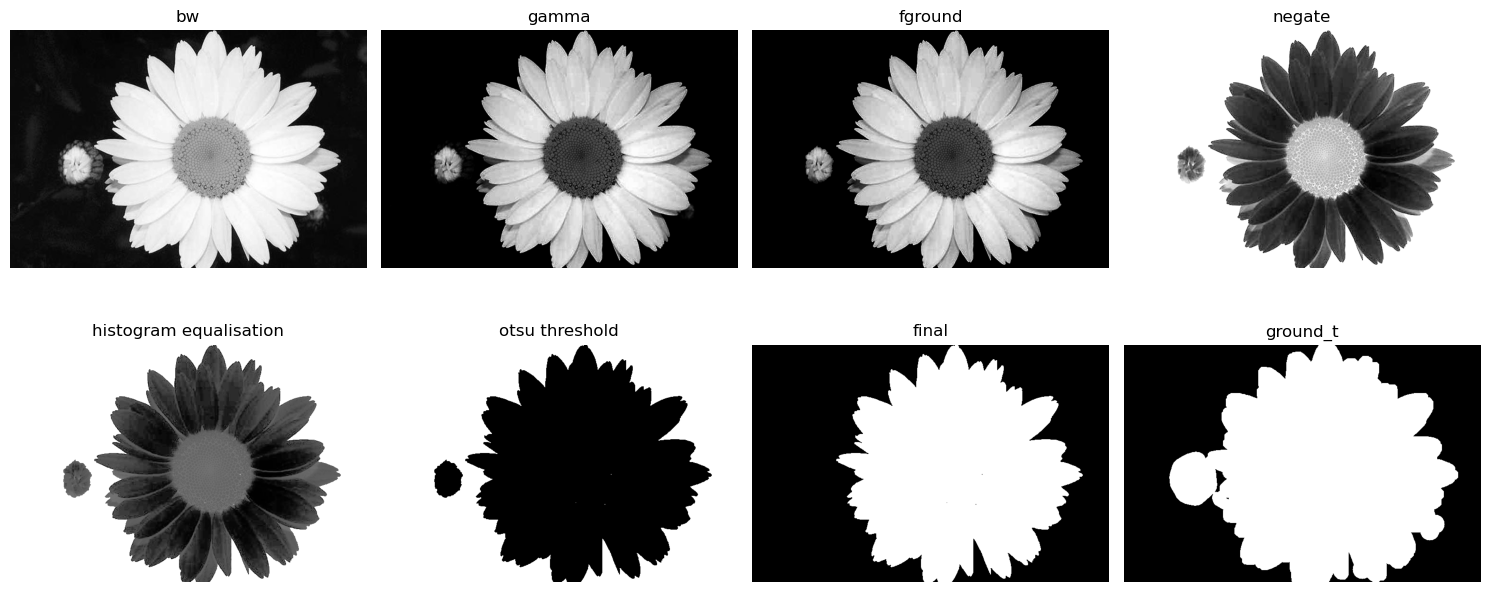

(500, 538)
(500, 538)
miou similarity:  0.988888877083902
iou similarity:  0.8171152833145823


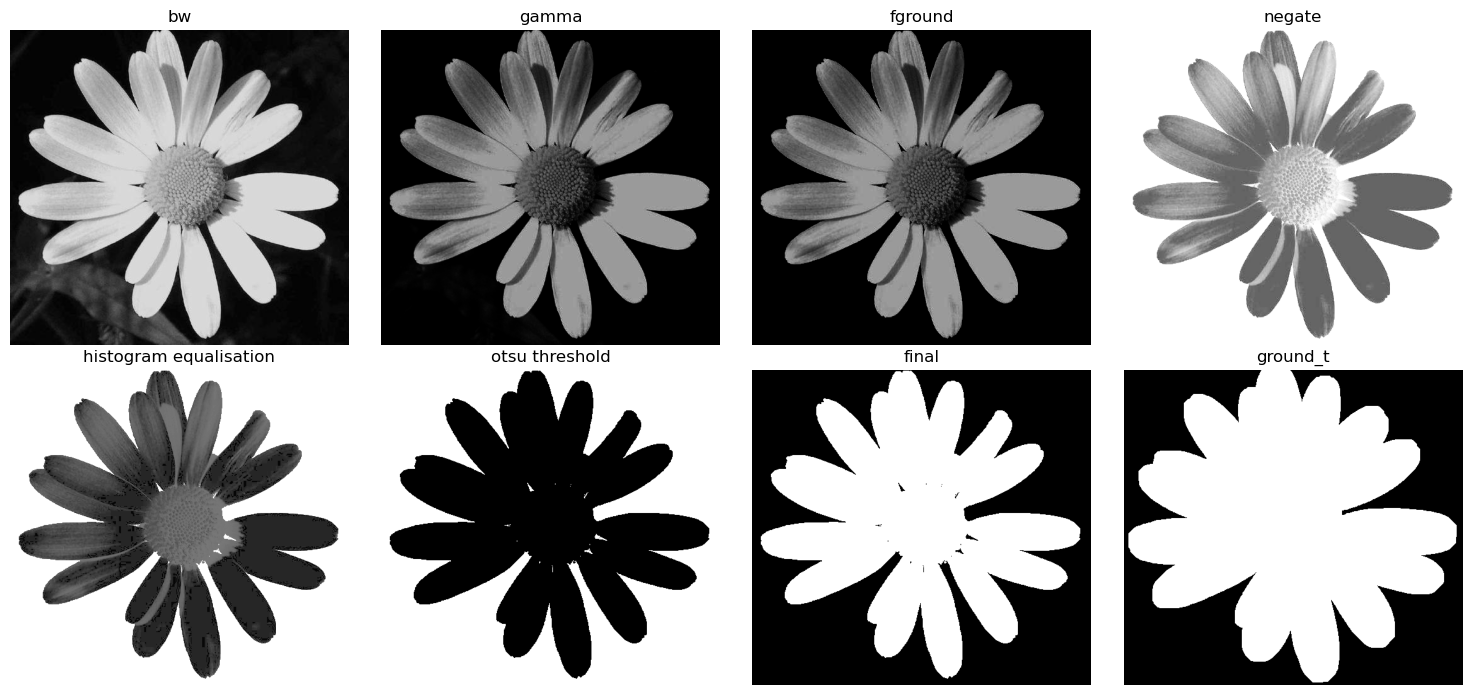

(500, 518)
(500, 518)
miou similarity:  0.99343466661362
iou similarity:  0.8941086846114779


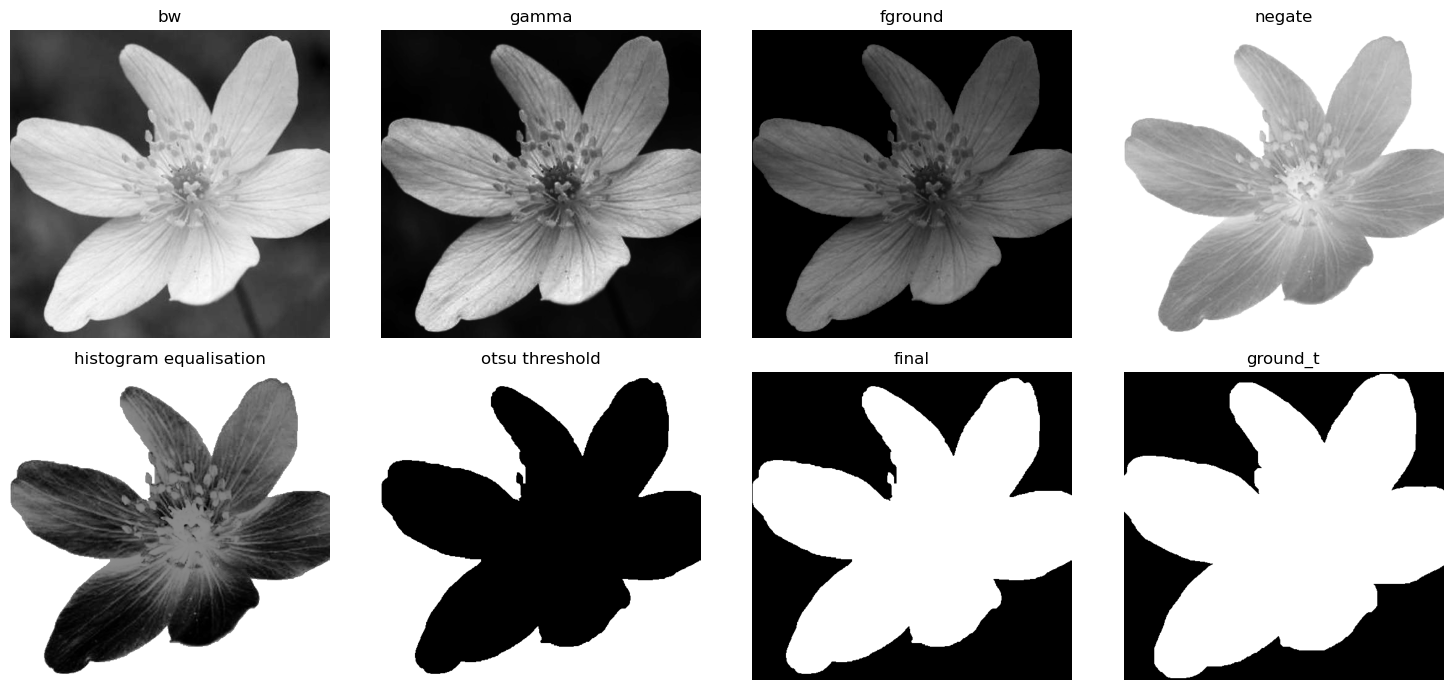

(500, 600)
(500, 600)
miou similarity:  0.9933893395615876
iou similarity:  0.8875359670029761


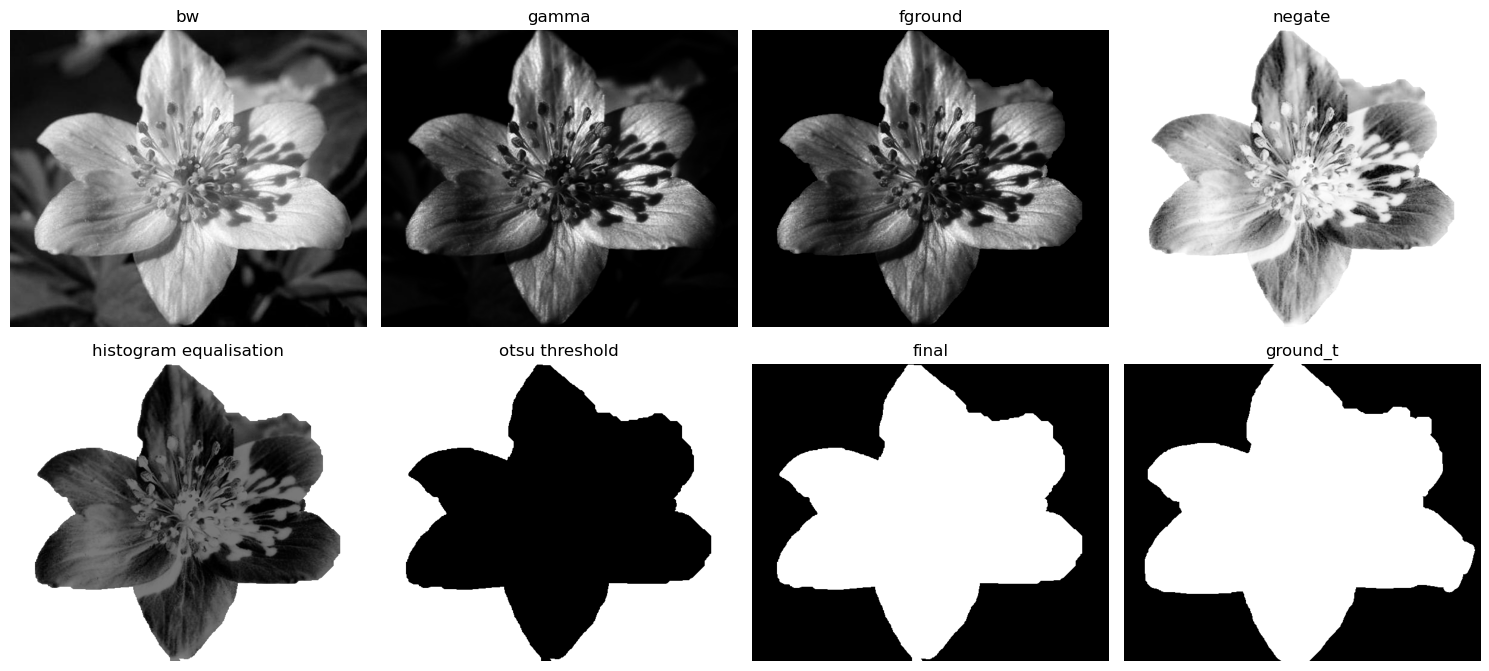

(500, 500)
(500, 500)
miou similarity:  0.9947363885162049
iou similarity:  0.9094597735966018


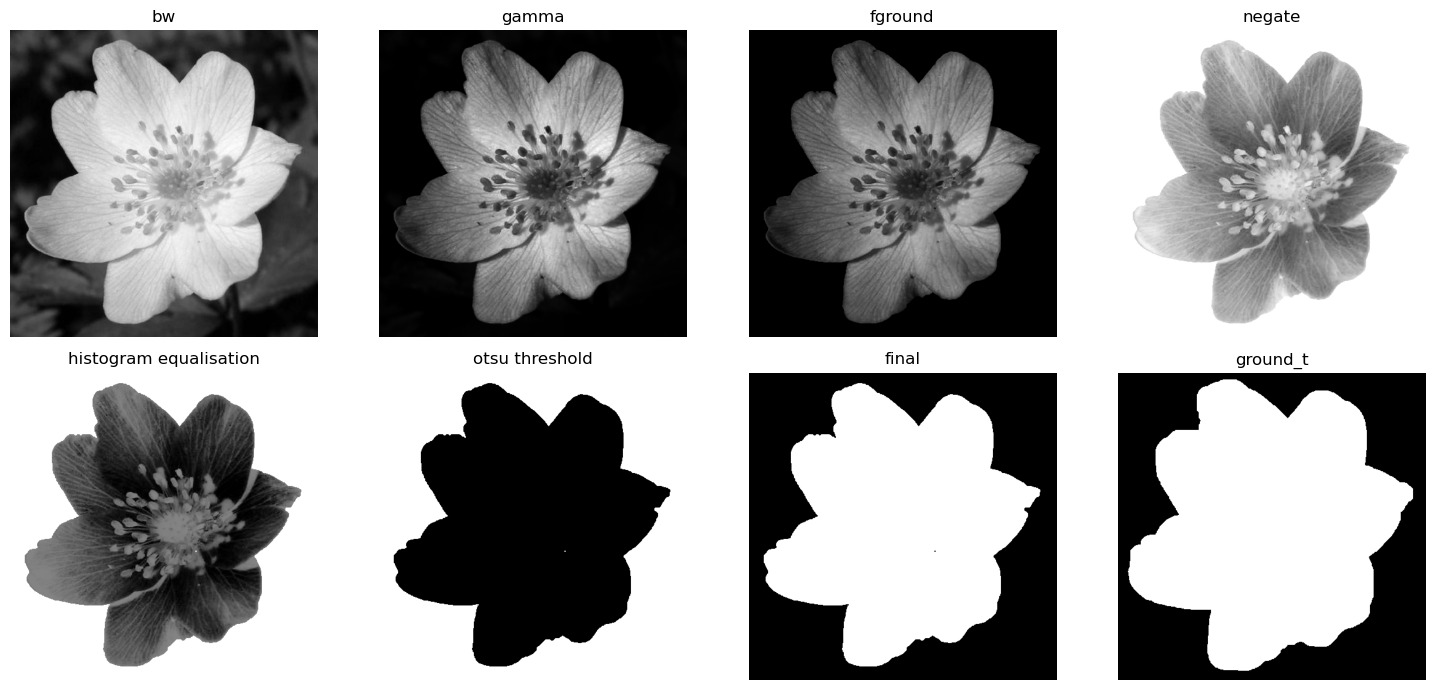

In [74]:
display_pipeline(image_pipeline)